# Setup

In [7]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Parameters

In [8]:
binwidth = 1

# Read Data

In [10]:
# get data from tigress
infn = '../CD/cd_woa.nc'

ds = xr.open_dataset(infn)
ds

<xarray.Dataset>
Dimensions:  (lat: 200, lon: 340, month: 12)
Coordinates:
  * lon      (lon) float64 35.12 35.38 35.62 35.88 ... 119.1 119.4 119.6 119.9
  * lat      (lat) float64 -19.88 -19.62 -19.38 -19.12 ... 29.38 29.62 29.88
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TCP      (month, lat, lon) float64 ...
    OCP      (month, lat, lon) float64 ...
    HCP      (month, lat, lon) float64 ...

In [11]:
def latlon_coarsen(invar,lat,lon,bounds,binwidth = 1):
    import numpy as np
 
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon)
        ))
    
    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)

    return np.array(invar_binned_ave,dtype = float),lonbins,latbins

# Put into bins

In [14]:
# grid lat lon data
xx,yy = np.meshgrid(ds.lon,ds.lat)

# define extent of grid
bounds = [35,120,-20,30]

_,lonbins,latbins =latlon_coarsen(np.array(ds.TCP[0,:,:]).ravel(),yy.ravel(),xx.ravel(),bounds,1)

# TCP
TCP_binned = np.zeros([ds.TCP.shape[0],len(latbins),len(lonbins)])
for tt in range(ds.TCP.shape[0]):
    TCP_binned[tt,:,:],_,_= latlon_coarsen(np.array(ds.TCP[tt,:,:]).ravel(),
                                               yy.ravel(),xx.ravel(),bounds,binwidth)
# doxy
OCP_binned = np.zeros([ds.OCP.shape[0],len(latbins),len(lonbins)])
for tt in range(ds.OCP.shape[0]):
    OCP_binned[tt,:,:],_,_= latlon_coarsen(np.array(ds.OCP[tt,:,:]).ravel(),
                                               yy.ravel(),xx.ravel(),bounds,binwidth)
# psal
HCP_binned = np.zeros([ds.HCP.shape[0],len(latbins),len(lonbins)])
for tt in range(ds.HCP.shape[0]):
    HCP_binned[tt,:,:],_,_= latlon_coarsen(np.array(ds.HCP[tt,:,:]).ravel(),
                                               yy.ravel(),xx.ravel(),bounds,binwidth)
    

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mea

AttributeError: 'Dataset' object has no attribute 'pres_grid'

TypeError: Dimensions of C (50, 85) are incompatible with X (340) and/or Y (200); see help(pcolormesh)

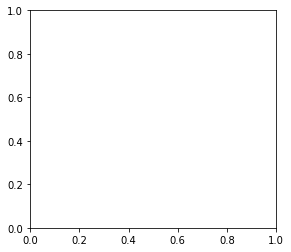

In [29]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1,3,1)
plt.pcolormesh(xx,yy,ds.TCP[0,:,:],cmap=plt.cm.PuOr_r)

ax = fig.add_subplot(1,3,2)
plt.pcolormesh(lonbins,latbins,TCP_binned[0,:,:],cmap=plt.cm.PuOr_r)


In [22]:
# convert to xarray dataset
ds=xr.Dataset(coords={'lon': lonbins,
                    'lat': latbins,
                    'month': ds.month})

# add variables to dataset

ds["TCP"]=xr.DataArray(TCP_binned,dims = ['month','lat', 'lon'],
                     coords =[ds.month,latbins,lonbins])
ds["OCP"]=xr.DataArray(OCP_binned,dims = ['month','lat', 'lon'],
                     coords =[ds.month,latbins,lonbins])
ds["HCP"]=xr.DataArray(HCP_binned,dims = ['month','lat', 'lon'],
                     coords =[ds.month,latbins,lonbins])
ds.to_netcdf('../CD/cd_woa_' + str(binwidth) + '_degree_binned.nc',mode='w',format = "NETCDF4")

ds

<xarray.Dataset>
Dimensions:  (lat: 50, lon: 85, month: 12)
Coordinates:
  * lon      (lon) float64 35.0 36.0 37.0 38.0 39.0 ... 116.0 117.0 118.0 119.0
  * lat      (lat) float64 -20.0 -19.0 -18.0 -17.0 -16.0 ... 26.0 27.0 28.0 29.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TCP      (month, lat, lon) float64 nan nan 35.24 37.75 ... nan nan nan nan
    OCP      (month, lat, lon) float64 nan nan 40.27 40.27 ... nan nan nan nan
    HCP      (month, lat, lon) float64 nan nan 40.27 142.9 ... nan nan nan nan